In [229]:
from sumolib import checkBinary
import xml.etree.ElementTree as ET
import traci
import sys
import random
import numpy as np


In [230]:
POPULAION_SIZE = 20
INTERMEDIATE_SIZE = 40
MUTATION_PERCENTAGE = 10
NO_OF_GENERATIONS = 10

In [231]:
waiting_times_data = []
accidents_data = []

In [232]:
class TrafficLightPattern:
    
    def __init__(self, genotype_size):
        self.size = genotype_size
        self.genotype = np.random.randint(2, size = genotype_size)
        self.phenotype = 0
        self.waiting_time = float('inf')
      
    def set_genotype(self, genotype):
        if len(genotype) == self.size:
            self.genotype = genotype
        else:
            print("Size error for the new genotype")
    
    def get_genotype(self):
        return self.genotype
    
    def set_phenotype(self, phenotype):
        self.phenotype = phenotype
    
    def get_phenotype(self):
        return self.phenotype
    
    def set_waiting_time(self, waiting_time):
        self.waiting_time = waiting_time
    
    def get_waiting_time(self):
        return self.waiting_time
    

In [233]:
#test_pattern = TrafficLightPattern(188)
#test_pattern.set_phenotype(phenotype(test_pattern.get_genotype()))
#print(test_pattern.get_phenotype())
#test_pattern.set_genotype(np.random.randint(2, size = 189))

In [234]:
def simulate(program):
    '''return the waiting time after running the simulation'''
    
    traci.start([checkBinary(program), "-c", "sumo/light.sumocfg", "--tripinfo-output", "sumo/tripinfo.xml"])
    
    accidents = 0
    while traci.simulation.getMinExpectedNumber() > 0:
        traci.simulationStep()
        accidents += traci.simulation.getCollidingVehiclesNumber()
        
        
    traci.close()
    sys.stdout.flush()
    
    xmldoc = ET.parse('sumo/tripinfo.xml')

    tripinfos = xmldoc.findall('tripinfo')

    waiting_time = 0
    for tripinfo in tripinfos:
        waiting_time += float(tripinfo.get('waitingTime'))
        
    return waiting_time, accidents

In [235]:
def phenotype(genotype):
    '''return phenotype when gives a genotype'''
    phenotype = []
    m = ['G', 'g', 'y', 'r']
    
    for j in range(4):
        phenotype.append(int(''.join(map(str,genotype[:7])),2)) 

        state = genotype[7:47]
        s = ""
        for i in range(0, 20):
            s += m[int(str(state[2*i])+str(state[2*i+1]),2)]
        phenotype.append(s)

        genotype = genotype[47:]
    
    return phenotype

In [236]:
def evaluate_pattern(phenotype):
    '''run the simulation after setting the new phenotype then return the waiting_time'''
    
    network = ET.parse('sumo/light.net.xml')
    signal = network.find('tlLogic') 
    
    i = 0
    for phase in signal.iter('phase'):
        
        duration = str(phenotype[2*i])
        if duration == "0":
             return float('inf')
        phase.set("duration", duration)
            
        state = phenotype[2*i+1]
        phase.set("state", state)
        i += 1
        
    network.write("sumo/light.net.xml")
    
    waiting_time,accidents = simulate('sumo')

    return waiting_time

In [237]:
def evaluate_population(population):
    times = []
    accident_list = []
    
    for pattern in population:
        waiting_time,accidents = evaluate_pattern(pattern.get_phenotype())
        pattern.set_waiting_time(waiting_time)
        times.append(waiting_time)
        accident_list.append(accidents)
        
    waiting_times_data.append(times)
    accidents_data.append(accident_list)

In [238]:
def create_new_population(population_size, genotype_size):
    
    population = []
    
    while (len(population) < population_size):
        light_pattern = TrafficLightPattern(genotype_size)
        if(not already_in(light_pattern, population)):
            light_pattern.set_phenotype(phenotype(light_pattern.get_genotype()))
            population.append(light_pattern)
            
    return population


In [239]:
# pop = create_new_population(3,188)

# print(pop[0].get_phenotype())
# print(pop[1].get_phenotype())
# answer = crossover(pop[0],pop[1])


# answer.set_phenotype(phenotype(answer.get_genotype()))
# print(answer.get_phenotype())

In [240]:
def crossover(pattern_1, pattern_2):
    
    genotype_1 = np.copy(pattern_1.get_genotype())
    genotype_2 = np.copy(pattern_2.get_genotype())

    new_pattern = TrafficLightPattern(pattern_1.size)
    
    new_genotype = []
    
    for i in range(4):
        time = genotype_1[:7] if random.randint(1,100) > 50 else genotype_2[:7] 
        
        new_genotype = np.concatenate((new_genotype, time)).astype(int)
        for j in range(7,47,2):
            new_genotype = np.concatenate((new_genotype, genotype_1[j:j+2] if random.randint(1,100) > 50 else genotype_2[j:j+2])).astype(int)

        genotype_1 = genotype_1[47:]
        genotype_2 = genotype_2[47:]
        
    new_pattern.set_genotype(new_genotype)
    return new_pattern

In [241]:
def mutation(pattern):

    new_pattern = TrafficLightPattern(pattern.size)
    new_genotype = np.copy(pattern.get_genotype())
    
    how_much = random.randint(1,pattern.size)
    for i in range(how_much):
        index = random.choice(range(0,pattern.size))
        new_genotype[index] = not new_genotype[index] 
    new_pattern.set_genotype(new_genotype)
    return new_pattern

In [242]:
# a=TrafficLightPattern(20)
# print(a.get_genotype())
# b = mutation(a)
# print(b.get_genotype())

In [243]:
def already_in(new_genotype, population):
    return next((True for elem in population if np.array_equal(elem.get_genotype(), new_genotype.get_genotype())), False)

In [244]:
# a = []
# a.append(TrafficLightPattern(10))
# a.append(TrafficLightPattern(10))
# b = TrafficLightPattern(10)
# print(b.get_genotype())
# c = TrafficLightPattern(10)
# print(c.get_genotype())
# c.set_genotype(np.copy(b.get_genotype()))
# a.append(b)

# print(b.get_genotype())
# print(c.get_genotype())

# already_in(c,a)

In [245]:
def select_candidates(population, size):
    population.sort(key = lambda x: x.get_waiting_time(), reverse=False)
    return population[0:size]

In [246]:
def next_generation(population, size, mutation_percentage):
    new_population = population
    while(len(new_population)<size):
        if (random.randint (1,100) > mutation_percentage):
            # do crossover 
            pattern1 = random.choice(new_population)
            pattern2 = random.choice(new_population)
            new_pattern = crossover(pattern1, pattern2)
            if(not already_in(new_pattern,new_population)):
                new_pattern.set_phenotype(phenotype(new_pattern.get_genotype()))
                new_population.append(new_pattern)
        
        else:
            # do mutation
            pattern = random.choice(new_population)
            new_pattern = mutation(pattern)
            if(not already_in(new_pattern,new_population)):
                new_pattern.set_phenotype(phenotype(new_pattern.get_genotype()))
                new_population.append(new_pattern)
            
    return new_population

In [247]:
# pop = create_new_population(2,188)
# for i in pop:
#     print(i.get_phenotype())
    
# print("__________________________")
# pop2 = next_generation(pop,5,10)
# for i in pop2:
#     print(i.get_phenotype())

In [248]:
def controller():
    genotype_size = 188
    population = create_new_population(POPULAION_SIZE,genotype_size)
    
    for i in range(NO_OF_GENERATIONS):
        next_gen = next_generation(population, INTERMEDIATE_SIZE, MUTATION_PERCENTAGE)
        evaluate_population(next_gen)
        population = select_candidates(next_gen,POPULAION_SIZE)
            
controller()

[51, 'rrGGyrgggrryGGGGGGGG', 114, 'rryyygrgrrrrrygrryGy', 78, 'rGggGGgGGrrgygryyyGg', 44, 'GryrGgggrryyryGGGGGG']
 Retrying in 1 seconds
[64, 'GyrrggrrGGryyyyyrgGr', 8, 'ryygyyyryGygrgyGrGGr', 59, 'gyrygrgGrrGygyrGGryy', 65, 'rggyGrrGgryyryyryyGr']
 Retrying in 1 seconds
[65, 'yrgryGGygGyyyyGgggGg', 55, 'rgyGgrgyGyGgyGyryGgG', 4, 'GgGrGGGGgggygGrggGGy', 56, 'gryrGGgrGryGGGGrGrgg']
 Retrying in 1 seconds
[50, 'yryyGrgryggrgGGgyygy', 122, 'GggrgrGyGrrryyygrrrG', 24, 'rgGGGyyyGyggygrgyygg', 21, 'rrGyyryrGrgyyryGrryr']
 Retrying in 1 seconds
[102, 'GyggyGGGgrGrgyGryGgy', 53, 'GyrygryggGyyrgGGGyyg', 95, 'GGGygGyrrggyrrgyrygy', 18, 'GyGgyyrGgyggrgGrrygg']
 Retrying in 1 seconds
[97, 'rrygryGgrGggGrGrGGrr', 38, 'rgyGGggrGryyggGGGrgy', 45, 'yyyygyrrryyGrGggryry', 91, 'ryGGrrrgrygggGryyGGr']
 Retrying in 1 seconds
[35, 'gGrgggGrGrrGGyGyryGr', 31, 'rGGryryyGGyyyrgGyyrG', 29, 'GggygGrGGrryGyGyyrgg', 38, 'GGgrgyyygGrGggrrggyr']
 Retrying in 1 seconds
[113, 'GrGgGgrGryrgrGggrygg', 34, 'GrryGyyrGyyG

[13, 'yrygyrggygrgrgygyyyr', 35, 'gyrGyrgygrrgrGrrggyg', 89, 'gyrgGgGgrrGrGgGygggr', 66, 'GGGgGrgyryygryyggrrr']
 Retrying in 1 seconds
[5, 'rgyGGGgygGyggryGyGgr', 34, 'gGGrGgyGGyGGryrgyrGr', 87, 'rrGryGyyGryyrggrGryg', 61, 'GGGygGrgrrggyGyggrGr']
 Retrying in 1 seconds
[41, 'gggryyryrryyyyygyygr', 55, 'ggrGgrggryygrGgrGrgy', 44, 'yrrgyGGggggyggggyGGg', 66, 'yrygGgryGryGyrrrgggg']
 Retrying in 1 seconds
[97, 'rrggryGgrrygGyyrGygr', 55, 'ggyGGrgrrrygrGGrGrgy', 45, 'yrrygyGgrgyyrgggyyGy', 66, 'yrygGrrgryyGgGrygGGg']
 Retrying in 1 seconds
[13, 'gyygGrGGryrgrgrgryyr', 35, 'ggyryrGyrrrrrGyyggyy', 7, 'gGrgGggGrrGgGyGgygGg', 57, 'GGGgGryyGgyyrygggyrG']
 Retrying in 1 seconds
[97, 'rrryygrggGggGrGrGGgr', 13, 'rgrGGggrGrrrgyGrGyGy', 85, 'yrrGgyrrrygygGgggyry', 91, 'GrGGrrryrrGGgGGyygGr']
 Retrying in 1 seconds
[97, 'rygyGgrgyGggGGyrGGgg', 13, 'rgGGGygGGGGrggGrGgyy', 8, 'GrrygyrgrGgygGGggyry', 91, 'GrGGryyGrrGGgrGgyGGr']
 Retrying in 1 seconds
[94, 'rggyyyrrgryygyygyygr', 13, 'ggrGgrggryrryygrG

[89, 'yyGgGggyyGGggGGgrygy', 13, 'GggrgrGGGryGyyGGrGgy', 52, 'yrGyGyyryyGryGrGGyyG', 89, 'ygGggGGryyyyrgygrrGG']
 Retrying in 1 seconds
[38, 'GygrGgrGrygGgGgrgGgg', 26, 'ygyyGygyrGygygGyygGg', 8, 'GrGryrrrgGgyyGgrygGG', 68, 'GyyGyygGyyrGyrrGrryG']
 Retrying in 1 seconds
[1, 'ryGyGrgGyyrygGyrrGgr', 69, 'gGrrGyGygggyrgGrGgGg', 89, 'grGygrGGyGGgGGGyyyGr', 62, 'yyyGrgyGggggrGrgrygG']
 Retrying in 1 seconds
[97, 'GygrGgrgrygggGgrGGgg', 26, 'rgyyGygyGGGgggGyGgyy', 8, 'GrGygyrggGgygGGgggry', 68, 'GrGGryyGrrGGyrrGrrGr']
 Retrying in 1 seconds
[1, 'ryGyGggGygrGgGryrGgr', 13, 'gGrrGyGrgggyygGyGyGg', 85, 'ggGyggGryGryrGgGgyGy', 62, 'ygGGrgrGggGgGGGrrygr']
 Retrying in 1 seconds
[94, 'rrGyygrrrggGgGryyygr', 13, 'gGrryrGrGggryyGyGyGy', 85, 'yggGGggryGryrGgGgyyy', 24, 'GgGGrgrggyGGGgGryrgr']
 Retrying in 1 seconds
[97, 'rGGyygrryrgrgGGrGGgr', 13, 'ygyGGrgGGgrrGgGrGgyy', 8, 'GryyggrgrrgGgGggyGyy', 91, 'GrrGryyGrrGygrGgygGG']
 Retrying in 1 seconds
[1, 'rygyGggGyygggGyrrGgg', 13, 'ygGyGyGGGGGGrgGGGgyy

[66, 'ryGygGryrgGyyggGggGG', 95, 'ggryyygGgGgGyrGGrryg', 105, 'yryGGyyGyGrrGGGyrrgG', 85, 'ggryyGyyGrGrrryGGygy']
 Retrying in 1 seconds
[113, 'ryGyGgrGyGrygGyrGGrr', 13, 'ggGGGygGGGGGggGrGgGy', 8, 'gyGygyrgyGGyggGGgyry', 88, 'yrygrGrgrgGGrgGgrGgr']
 Retrying in 1 seconds
[1, 'ryGyGrgGyyryggyrrGgr', 13, 'gGrGGrGGGggGrgGGGgGg', 89, 'gyGygyyGyyGgGgGyyyGG', 62, 'yyyGrgyGggggrGGgrygr']
 Retrying in 1 seconds
[89, 'ryGgGggGyyGGgGGgrygy', 35, 'ggGrgrgyGrgGyGGGrGgy', 52, 'yrryGyygyyGrGyGGgyyG', 89, 'GGGggrGGryGyGgGgrrgr']
 Retrying in 1 seconds
[89, 'ryGgGgrGyyrygGygGGry', 13, 'ggGGGrgyGrgGggGGGGGy', 52, 'yyGyGyrgyyGrggGGgyyy', 88, 'GrGgrrGGrgGyGgGgrrgr']
 Retrying in 1 seconds
[113, 'ryGyGgrGyGrGGGyrGGrr', 13, 'rgGGGygGGGGGggGrGgyy', 8, 'grGygyrgyGGyggGGgyry', 88, 'GrGgrgrgrgGGrGGgyGgr']
 Retrying in 1 seconds
[97, 'ryGyGrrGyGgyGGyrrGgg', 13, 'rgrGGyGGGggGggGrGgyy', 85, 'gyrygyyGyyGygGGggyGG', 62, 'GrygrgrGggggGGGgrGgr']
 Retrying in 1 seconds
[1, 'ryGyGrgGygrGgGyyrGrr', 13, 'ggrGGyGrGrGGygG

[38, 'GyGyGgrggGgyGGygGygr', 13, 'rgGGGyGGrgyrggGrGggy', 85, 'grrgyyygyyGygGgryygy', 91, 'GrGGrgryggGGyrGGrggr']
 Retrying in 1 seconds
[38, 'GyryGgrgggggyGyrrGgr', 13, 'ggGGyrgGrgyrrggrGggy', 8, 'GgGgyyggrggyyGgryyGG', 24, 'GrGGygyyryGGyrGGrryr']
 Retrying in 1 seconds
[1, 'ryGyGgrGyygGgGygrygg', 35, 'ggGryrgyGGgyrGGyGgGy', 8, 'grrygyGgrGGyGyGggyGy', 57, 'GGGgrryGrrGGGrGgrGgr']
 Retrying in 1 seconds
[1, 'ryGyGrgGyyryggyyrGrr', 13, 'ggGGGrGGGrGGrgGGGgGg', 27, 'gyGygyygyGGgrgGrGygG', 62, 'yyygGGyggrgGrgGgrygr']
 Retrying in 1 seconds
[38, 'GgryGgrGggygyGGgrygr', 13, 'ggGGyrgyGGgGrGGrrGgy', 8, 'yrrgGyygryGyGyGGgygy', 89, 'GrGGygGGryGGGgGGrrgr']
 Retrying in 1 seconds
[38, 'GgryGgrgggygyGygGygr', 13, 'gyGGyrgGrGyrrgGrGggy', 8, 'GrrgyyggrggygGgryGgy', 91, 'GrGGygyyrrGGyrGGrgGr']
 Retrying in 1 seconds
[66, 'ryGygrryrgGyGGyGgggG', 95, 'rgrGyygGgggGgrGrrryg', 105, 'grrGgyyGyGryGGGgrygG', 85, 'gryyyGryGrggGGygrGgy']
 Retrying in 1 seconds
[66, 'ryGygGryrgGyyggGggGG', 95, 'ggryyygGgGgGyrGGrry

[66, 'ryGyggryrgygyGyGGygG', 95, 'ggrGyygGrggrgrGrrgyg', 8, 'GrrGyyygrGgyGGGryGgG', 91, 'grGyyGyyrrgGGrGGrGgy']
 Retrying in 1 seconds
[1, 'ryGyyGrGygrGggyGrGgG', 69, 'gGGGyrGygrgGrGGGGryg', 8, 'yyGygyyGyGGrGGGGgrGG', 62, 'yyGgyryGGrgGrGGgrygr']
 Retrying in 1 seconds
[38, 'GgryGgrgggggyGyrGygr', 13, 'ggGGyrgGrGyrrggrGggy', 8, 'GgGgyyggrggygGgryGgG', 24, 'GrGGygyyryGGyrGGrgGr']
 Retrying in 1 seconds
[1, 'yyGyGGryygGyyggGryGG', 95, 'GggyyrGGGGgGyrGGGrgg', 105, 'yryyGyyGyGGryGGyGrgG', 62, 'ggyygGGrGgGrrGyGGygy']
 Retrying in 1 seconds
[1, 'gyGyGggGyygyrgyygGgr', 69, 'yyyGGyGygGGgrggGygGy', 27, 'yyrygyyGyGggGGgyyygG', 62, 'yyyGryyGgrgGyGGgrrgg']
 Retrying in 1 seconds
[1, 'ryGgGGgyyGgggggGrgGG', 95, 'GggyyygGgrgGygGGGrGg', 105, 'GryryyyGyGgyyGgrrggG', 68, 'ggyGgGgyGgGryGyGrrgr']
 Retrying in 1 seconds
[38, 'ryGyGrgggygyGgyyryrr', 69, 'rGGGGrGGgrgGrggrGgGg', 27, 'grGyygygyGGyGGgyyygG', 62, 'yrygrgyygrGGyrGgrygG']
 Retrying in 1 seconds
[1, 'ryGyGrgGyyrGggyyrGrr', 13, 'gGGGGrGGGrGGrgGGGgGg

[1, 'ryGyGrgGyyrGgGyyrGrr', 13, 'gGGGGyGrGrGGygGyGgGg', 85, 'gyGyggyryGGyrGGGgygG', 62, 'ygGgrgrggggGGGGgrygr']
 Retrying in 1 seconds
[38, 'GgryGgrgggggyGyrGygr', 13, 'ggGGyrgGrGyrrggrGggy', 8, 'GgGgyyggrggygGgryGgG', 24, 'GrGGygyyryGGyrGGrgGr']
 Retrying in 1 seconds
[38, 'GyGyGggggGgyGGygGygr', 13, 'rgGGGyGGGgyrgggrGgGy', 85, 'grrgyyygygGygGgryygG', 62, 'yrGgrgrygyGGyrGGrggr']
 Retrying in 1 seconds
[38, 'GyGygrgygGGgygyrryrr', 35, 'rrGGGrGGGgyrgggrGyGG', 76, 'GgGgyrGgGGGygGgGgyrG', 62, 'ryrGrgryrryGryygrygy']
 Retrying in 1 seconds
[38, 'GyGyGGrygGGyyGgGryrr', 13, 'rggGGrGGGGgryrgGGrGy', 85, 'GrrgygygygGryGGyyrgG', 62, 'ygyyggrrrgGGyGGGrygy']
 Retrying in 1 seconds
[1, 'ryGyyGrGygrGggyGrGgG', 69, 'gGGGyrGygrgGrGGGGryg', 8, 'yyGygyyGyGGrGGGGgrGG', 62, 'yyGgyryGGrgGrGGgrygr']
 Retrying in 1 seconds
[1, 'yyGgGGgyyGGgygGGrygG', 95, 'GggygrGGGrgGygGGGrgg', 105, 'yryyGyyryGGryGGGGygG', 62, 'ygygggGrGgGrrGygrrgr']
 Retrying in 1 seconds
[38, 'GyGyGrgggGGyGGyrGyrr', 35, 'rrGGGrGGGgyrgggrGy

In [249]:
# population = create_new_population(2,188)
# next_gen = next_generation(population, 5, 10)
# for i in next_gen:
#     print(i.get_waiting_time())
# evaluate_population(next_gen)
# for i in next_gen:
#     print(i.get_waiting_time())

In [250]:
# next_gen.sort(key = lambda x: x.get_waiting_time(), reverse=False)
# for i in next_gen:
#     print(i.get_waiting_time())

In [251]:
# print(waiting_times_data)

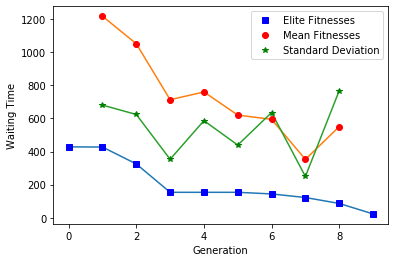

NameError: name 'accidents_data' is not defined

In [259]:
from statistics import mean, stdev
import matplotlib.pyplot as plt

'''Waiting time data'''

elite_fitnesses = []
mean_fitnesses = []
stdev_fitnesses = []

for i in waiting_times_data:
    elite_fitnesses.append(min(i))
    mean_fitnesses.append(mean(i))
    stdev_fitnesses.append(stdev(i))


plt.plot(elite_fitnesses)
plt.plot(mean_fitnesses)
plt.plot(stdev_fitnesses)


plt.plot(elite_fitnesses,'bs', label='Elite Fitnesses')
plt.plot(mean_fitnesses, 'ro', label='Mean Fitnesses')
plt.plot(stdev_fitnesses, 'g*', label='Standard Deviation')


plt.xlabel('Generation')
plt.ylabel('Waiting Time')
plt.legend()
plt.show()

'''Accident data'''

max_accidents = []
mean_accidents = []

for i in accidents_data:
    max_accidents.append(max(i))
    mean_accidents.append(mean(i))
    
plt.figure()

plt.plot(max_accidents)
plt.plot(mean_accidents)


In [ ]:
a = [[1,2,3],[5,6,7],[2,3,4],[7,5,3]]
for i in 